# Instalación de librerias necesarias

In [ ]:
!pip install cupy-cuda12x
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q

print("Instalación completada")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 848.7/848.7 MB 1.8 MB/s eta 0:00:00
✅ Instalación completada


Se hace necesario conocer la versión de CUDA y de la del compilador para que el gestor tenga versiones compatibles

In [ ]:
# Verificar versión CUDA
!nvidia-smi
print("\n" + "="*50)
!nvcc --version

Fri Jun 20 17:19:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

# Verificar CuPy disponibilidad
try:
    import cupy as cp
    GPU_CUPY_AVAILABLE = True
    print("CuPy disponible")
    print(f"   GPU: {cp.cuda.runtime.getDeviceProperties(0)['name'].decode()}")
    print(f"   Memoria: {cp.cuda.runtime.memGetInfo()[1] / 1024**3:.1f} GB")
except ImportError:
  #No se pudo trabajar con CUDA, cambiar la versión o el entorno de ejecución
    GPU_CUPY_AVAILABLE = False
    print("   CuPy no disponible")

# Verificar PyTorch
try:
  #Verificación del paquete pytorch para calculos con GPU
    import torch
    GPU_TORCH_AVAILABLE = torch.cuda.is_available()
    if GPU_TORCH_AVAILABLE:
        print("    PyTorch GPU disponible")
        print(f"   GPU: {torch.cuda.get_device_name(0)}")
        print(f"   Memoria: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    else:
      #A cambiar el entorno de ejecución
        print("   PyTorch GPU no disponible")
except ImportError:
    GPU_TORCH_AVAILABLE = False
    print("    PyTorch no disponible")

print(f"\n🔧 Estado: CuPy={GPU_CUPY_AVAILABLE}, PyTorch={GPU_TORCH_AVAILABLE}")

    CuPy disponible
   GPU: Tesla T4
   Memoria: 14.7 GB
    PyTorch GPU disponible
   GPU: Tesla T4
   Memoria: 14.7 GB

🔧 Estado: CuPy=True, PyTorch=True


# Definición de la clase GPUMatrixInverter

Está diseñada para realizar la inversión de matrices utilizando la aceleración de GPU con CuPy (para GPUs NVIDIA) y PyTorch, usando los paquetes propios de cada libreria, llamando metodos de inversa y pseudo inversa.

## Comparación de metodos
En este caso, el método `compare_methods` se encarga de evaluar y comparar el rendimiento de diferentes librerías y algoritmos para el cálculo de la inversa de una matriz. Su objetivo principal es mostrar cuál método es más rápido y preciso para una matriz dada, aprovechando tanto la CPU como la GPU si están disponibles.

## Resultados
Se hace importante mencionar los valores de el diccionario `results`

* `time`: Esta variable representa el tiempo que tardó el método en calcular la  inversa de la matriz A. Se mide en segundos y se obtiene restando start_time (el momento en que comenzó el cálculo) de end_time (el momento en que terminó el cálculo). Un valor más bajo indica que el método es más rápido.

* `valid`: Esta es una variable booleana (es decir, puede ser True o False) que indica si la inversa calculada es considerada "válida" o suficientemente precisa. Se determina usando `np.allclose(A @ inv_matrix, np.eye(len(A)), atol=1e-5)`.

  * `np.allclose` compara dos arreglos (en este caso, el producto de A y inv_matrix con la matriz identidad) y devuelve True si son iguales dentro de una tolerancia específica (atol=1e-5).

  * Un valor de True significa que la matriz multiplicada por su inversa es muy cercana a la matriz identidad, lo que sugiere un buen resultado. False indica que la precisión no es suficiente.

* `error`: Como ya vimos, esta variable representa el máximo error absoluto entre el producto de la matriz original y su inversa calculada, y la matriz identidad. Un error más cercano a cero indica una mayor precisión en el cálculo de la inversa.

* `inverse`: Esta variable contiene la matriz inversa real calculada por el método correspondiente. Es decir, es el resultado directo de la función `method(A.copy())`. Esta es la matriz que, al multiplicarse por A, debería dar como resultado la matriz identidad (o algo muy cercano a ella).

In [ ]:
class GPUMatrixInverter:
    """
    Clase para inversión de matrices usando GPU, tnato con Cupy como con Torch
    Esta clase  permite:

    Realizar la inversión directa de matrices.
    Calcular la pseudo-inversa de matrices.
    Procesar múltiples matrices en lotes (batch processing).
    Comparar el rendimiento y la precisión de diferentes métodos de inversión (CuPy, PyTorch y NumPy).
    """

    def __init__(self):
      #inicializar constructor con la disponibilidad de las librerias
        self.cupy_available = GPU_CUPY_AVAILABLE
        self.torch_available = GPU_TORCH_AVAILABLE

    def cupy_inverse(self, A):
        """Inversión usando CuPy (NVIDIA GPU)"""
        if not self.cupy_available:
            raise RuntimeError("CuPy no está disponible")

        #Convertir matriz a procesar en objeto de CuPy
        A_gpu = cp.asarray(A, dtype=cp.float32)
        #calculo de la inversa, con el paquete cupy
        inv_gpu = cp.linalg.inv(A_gpu)
        return cp.asnumpy(inv_gpu)

    def cupy_pinv(self, A):
        """Pseudo-inversa usando CuPy (más estable)"""
        if not self.cupy_available:
            raise RuntimeError("CuPy no está disponible")

        A_gpu = cp.asarray(A, dtype=cp.float32)
        #Calculo de la pseudoinversa con la misma libreria
        pinv_gpu = cp.linalg.pinv(A_gpu)
        return cp.asnumpy(pinv_gpu)

##### TRABJAR CON PYTORCH

    def torch_inverse(self, A):
        """Inversión usando PyTorch GPU"""
        if not self.torch_available:
            raise RuntimeError("PyTorch GPU no está disponible")

        A_tensor = torch.tensor(A, dtype=torch.float32, device='cuda')
        #Usando el mismo paquete de algebra lineal, se calcula la invvsa del tensor
        inv_tensor = torch.linalg.inv(A_tensor)
        return inv_tensor.cpu().numpy()

    def torch_pinv(self, A):
        """Pseudo-inversa usando PyTorch GPU"""
        if not self.torch_available:
            raise RuntimeError("PyTorch GPU no está disponible")

        A_tensor = torch.tensor(A, dtype=torch.float32, device='cuda')
        #Se cuenta con el mismo metodo de pinv (pseudoinversa)
        pinv_tensor = torch.linalg.pinv(A_tensor)
        return pinv_tensor.cpu().numpy()

    def batch_inverse(self, matrices):
        """Inversión de múltiples matrices en lote"""
        if not self.cupy_available:
            raise RuntimeError("Requiere CuPy para procesamiento en lotes")
            #Para este caso hacemos el procesamiento de multiples matrices

        batch_gpu = cp.asarray(matrices, dtype=cp.float32)
        inv_batch_gpu = cp.linalg.inv(batch_gpu)
        return cp.asnumpy(inv_batch_gpu)

    def compare_methods(self, A, show_details=True):
        """Compara diferentes métodos disponibles"""
        methods = {}

        # Agregar métodos según disponibilidad
        if self.cupy_available:
            methods.update({
                'CuPy Inverse': self.cupy_inverse,
                'CuPy Pinv': self.cupy_pinv
            })

        if self.torch_available:
            methods.update({
                'PyTorch Inverse': self.torch_inverse,
                'PyTorch Pinv': self.torch_pinv
            })

        # CPU como referencia
        methods['NumPy CPU'] = np.linalg.inv
        #Se tiene un diccionario para tomar el metodo de inversion de matriz para cada comparación
        #Adicional se agrega un 5to metodo que realiza la comparativa de inversión usando numpy (with cpu)
        results = {}

        for name, method in methods.items():
            try:
                # Warmup para GPU
                if 'CuPy' in name or 'PyTorch' in name:
                    _ = method(A.copy())

                start_time = time.time()
                inv_matrix = method(A.copy())
                end_time = time.time()

                # Verificar precisión
                identity_check = np.allclose(A @ inv_matrix, np.eye(len(A)), atol=1e-5)
                error = np.max(np.abs(A @ inv_matrix - np.eye(len(A))))

                results[name] = {
                    'time': end_time - start_time,
                    'valid': identity_check,
                    'error': error,
                    'inverse': inv_matrix
                }

                if show_details:
                    print(f"{name}:")
                    print(f"   Tiempo: {results[name]['time']:.6f}s")
                    print(f"   Válido: {results[name]['valid']}")
                    print(f"   Error: {results[name]['error']:.2e}")
                    print()

            except Exception as e:
                results[name] = {'error': str(e)}
                if show_details:
                    print(f"{name}:  Error - {e}")

        return results

print(" Clase GPUMatrixInverter creada")

 Clase GPUMatrixInverter creada


# Funciones de utilidad

En conjunto, estas funciones forman un sistema robusto para evaluar sistemáticamente la eficiencia y la precisión de algoritmos de inversión de matrices en diferentes configuraciones de hardware (CPU vs. GPU) y para distintos tamaños y tipos de matrices. La visualización final hace que los resultados sean fáciles de interpretar.

* Función `generate_matrix`:

    Esta función está diseñada para crear matrices de prueba con características numéricas específicas, las cuales son cruciales para realizar pruebas de rendimiento (benchmarking). Puedes controlar la "condición" de la matriz, lo que influye en cuán fácil o difícil es invertirla numéricamente.

 * `size`: Este parámetro define las dimensiones de la matriz cuadrada. Un size de N producirá una matriz de N x N.

 *  `condition`: Este parámetro de tipo cadena de texto controla la "condición" numérica de la matriz:

   * `'well'` (bien condicionada): Genera una matriz que es fácil de invertir de forma precisa. El código logra esto creando una matriz aleatoria, multiplicándola por su transpuesta (A @ A.T), y luego añadiendo una pequeña matriz identidad escalada por 0.1. Esta operación tiende a hacer que la matriz sea simétrica definida positiva, las cuales suelen estar bien condicionadas.

   * `'ill'` (mal condicionada): Genera una matriz que es difícil de invertir numéricamente. Esto significa que pequeños cambios en la entrada pueden llevar a grandes cambios en el resultado, y se puede perder precisión. Aquí, se añade un valor muy pequeño (1e-10) a la diagonal, lo que acerca la matriz a la singularidad (no invertibilidad).

    Cualquier otro valor (aleatoria estándar): Si condition no es 'well' ni 'ill', se genera una matriz aleatoria estándar sin un control específico sobre su condición.

 * `seed`: Establece la semilla para el generador de números aleatorios de NumPy. Usar una seed fija (como 42) asegura que las matrices "aleatorias" generadas sean exactamente las mismas cada vez que ejecutes la función. Esto es vital para benchmarks reproducibles, permitiéndote comparar métodos de manera justa entre diferentes ejecuciones.

* Función `benchmark_sizes`
Esta función organiza el proceso de evaluación del rendimiento (benchmarking) a través de diferentes tamaños de matriz. Automatiza la ejecución de tu método compare_methods (contenido en el objeto inverter) para varias dimensiones de matriz.

  * `inverter`: Este es un objeto (probablemente una instancia de la clase que contiene compare_methods) que tiene la funcionalidad para comparar diferentes técnicas de inversión de matrices.

  * `sizes`: Una lista de números enteros que representan las diferentes dimensiones de las matrices cuadradas (N x N) a probar. Por defecto, prueba matrices de 500x500, 1000x1000 y 5000x5000.

###Funcionamiento:
  Inicializa un diccionario vacío results para almacenar todos los datos del benchmark, posteriormente i tera sobre cada size en la lista sizes.

  Llama a generate_matrix(size) para crear una nueva matriz de prueba con el tamaño especificado.

  Luego, llama a `inverter.compare_methods(A, show_details=False`). Aquí es donde ocurre la comparación real de los métodos de inversión. `show_details=False` significa que compare_methods no imprimirá los resultados detallados de cada método individualmente; benchmark_sizes se encarga de mostrar solo los tiempos de forma resumida.

  Almacena los resultados de `compare_methods` para el tamaño actual en el diccionario results.
  Muestra solo los tiempos: Itera sobre los resultados de size_results (los resultados para el tamaño de matriz actual).

  Calcula y muestra un factor de aceleración (speedup) si el método no es 'NumPy CPU' y si 'NumPy CPU' también tiene un tiempo registrado. La aceleración se calcula como tiempo_numpy_cpu / tiempo_metodo. Esto te indica cuántas veces más rápido es el método actual en comparación con la referencia de CPU.
  Finalmente, la función devuelve el diccionario results completo con los tiempos y detalles de rendimiento para todos los tamaños probados.

* Función `plot_benchmark`:

   Esta función se encarga de visualizar los resultados del benchmark de una manera gráfica, permitiendo una fácil comparación del rendimiento de los diferentes métodos de inversión a medida que el tamaño de la matriz aumenta.

  * benchmark_results: Este es el diccionario de resultados devuelto por la función benchmark_sizes.



In [ ]:
def generate_matrix(size, condition='well', seed=42):
    """
    Genera matrices de prueba con diferentes características, utlidades!
    """
    np.random.seed(seed)

    if condition == 'well':
        # Matriz bien condicionada (fácil de invertir)
        A = np.random.randn(size, size).astype(np.float32)
        A = A @ A.T + np.eye(size) * 0.1
    elif condition == 'ill':
        # Matriz mal condicionada (difícil de invertir)
        A = np.random.randn(size, size).astype(np.float32)
        A = A @ A.T + np.eye(size) * 1e-10
    else:
        # Matriz aleatoria estándar
        A = np.random.randn(size, size).astype(np.float32)

    return A

def benchmark_sizes(inverter, sizes=[500, 1000, 5000]):
    """Benchmark con diferentes tamaños de matriz"""
    results = {}

    for size in sizes:
        print(f"\n Benchmarking {size}x{size}")
        A = generate_matrix(size)

        size_results = inverter.compare_methods(A, show_details=False)
        results[size] = size_results

        # Mostrar solo tiempos
        for method, result in size_results.items():
            if 'time' in result:
                speedup = ""
                if 'NumPy CPU' in size_results and method != 'NumPy CPU':
                    if 'time' in size_results['NumPy CPU']:
                        speedup_val = size_results['NumPy CPU']['time'] / result['time']
                        speedup = f" ({speedup_val:.1f}x más rápido)"

                print(f"  {method}: {result['time']:.4f}s{speedup}")

    return results

def plot_benchmark(benchmark_results):
    """Graficar resultados del benchmark"""
    methods = []
    sizes = list(benchmark_results.keys())

    # Obtener métodos disponibles
    for size_results in benchmark_results.values():
        for method in size_results.keys():
            if method not in methods and 'time' in size_results[method]:
                methods.append(method)

    plt.figure(figsize=(12, 8))

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

    for i, method in enumerate(methods):
        times = []
        valid_sizes = []

        for size in sizes:
            if method in benchmark_results[size] and 'time' in benchmark_results[size][method]:
                times.append(benchmark_results[size][method]['time'])
                valid_sizes.append(size)

        if times:
            plt.plot(valid_sizes, times, marker='o', label=method,
                    linewidth=3, markersize=8, color=colors[i % len(colors)])

    plt.xlabel('Tamaño de Matriz', fontsize=12)
    plt.ylabel('Tiempo (segundos)', fontsize=12)
    plt.title('Benchmark: Inversión de Matrices GPU vs CPU', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

print(" Funciones de utilidad creadas")

 Funciones de utilidad creadas


In [ ]:
###CASOS DE USO

#Uso del codigo

In [ ]:
inverter = GPUMatrixInverter()
#Objeto de la clase

# Generar matriz de prueba pequeña
A_small = generate_matrix(3)
print(" Matriz de prueba 3x3:")
print(A_small)
print()

# Comparar métodos
print("📊 Comparación de métodos:")
results = inverter.compare_methods(A_small)

 Matriz de prueba 3x3:
[[0.78534243 0.63723767 0.3742353 ]
 [0.63723767 2.52926764 2.33541179]
 [0.3742353  2.33541179 3.40327535]]

📊 Comparación de métodos:
CuPy Inverse:
   Tiempo: 0.000522s
   Válido: True
   Error: 1.89e-07

CuPy Pinv:
   Tiempo: 0.001621s
   Válido: True
   Error: 7.60e-07

PyTorch Inverse:
   Tiempo: 0.000522s
   Válido: True
   Error: 2.84e-07

PyTorch Pinv:
   Tiempo: 0.000813s
   Válido: True
   Error: 6.14e-07

NumPy CPU:
   Tiempo: 0.005324s
   Válido: True
   Error: 5.55e-16



#Grafica del benchmark

 Ejecutando benchmark completo...

 Benchmarking 100x100
  CuPy Inverse: 0.0009s (0.8x más rápido)
  CuPy Pinv: 0.0124s (0.1x más rápido)
  PyTorch Inverse: 0.0009s (0.8x más rápido)
  PyTorch Pinv: 0.0085s (0.1x más rápido)
  NumPy CPU: 0.0007s

 Benchmarking 500x500
  CuPy Inverse: 0.0059s (10.2x más rápido)
  CuPy Pinv: 0.0827s (0.7x más rápido)
  PyTorch Inverse: 0.0076s (8.0x más rápido)
  PyTorch Pinv: 0.0435s (1.4x más rápido)
  NumPy CPU: 0.0603s

 Benchmarking 1000x1000
  CuPy Inverse: 0.0421s (3.1x más rápido)
  CuPy Pinv: 0.1495s (0.9x más rápido)
  PyTorch Inverse: 0.0127s (10.2x más rápido)
  PyTorch Pinv: 0.1620s (0.8x más rápido)
  NumPy CPU: 0.1301s

 Benchmarking 5000x5000
  CuPy Inverse: 0.5128s (15.6x más rápido)
  CuPy Pinv: 10.3763s (0.8x más rápido)
  PyTorch Inverse: 0.3408s (23.5x más rápido)
  PyTorch Pinv: 21.0822s (0.4x más rápido)
  NumPy CPU: 8.0031s

 Benchmarking 10000x10000
  CuPy Inverse: 10.7100s (5.3x más rápido)
  CuPy Pinv: 85.1725s (0.7x más rápido

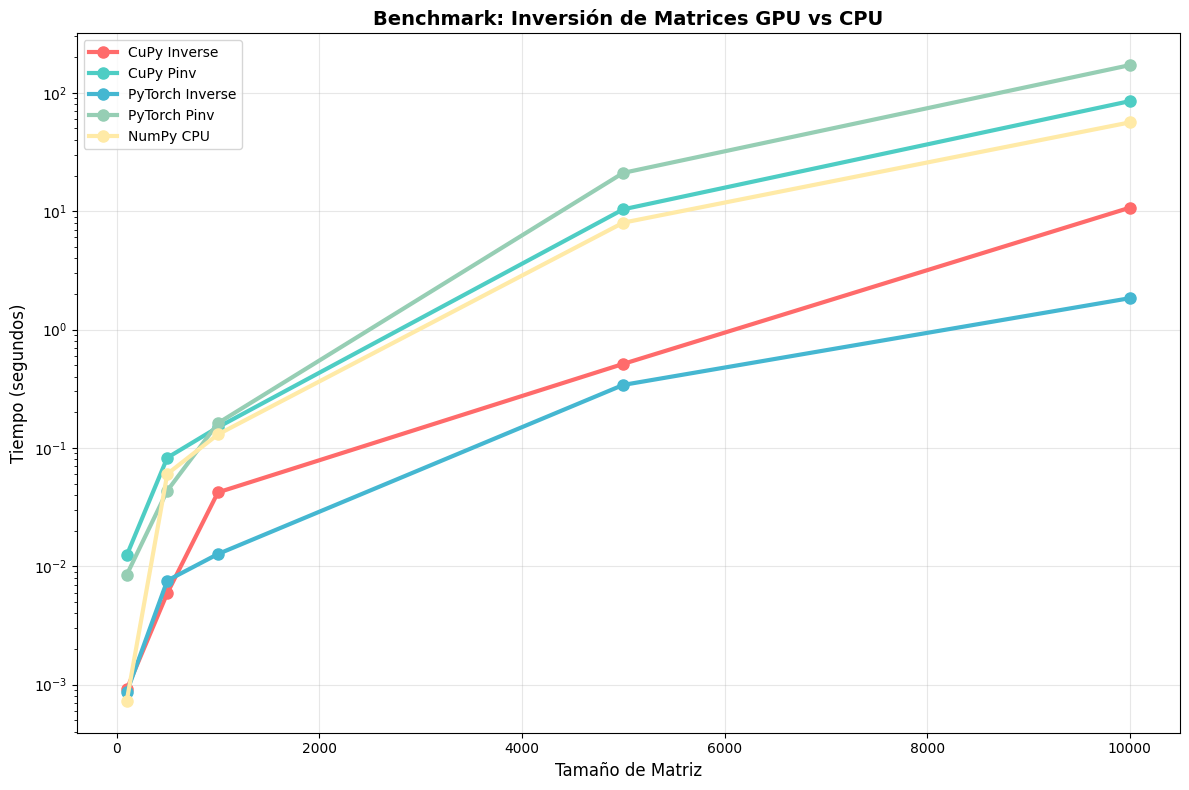

In [ ]:
# Ejecutar benchmark con diferentes tamaños
print(" Ejecutando benchmark completo...")
benchmark_results = benchmark_sizes(inverter, sizes=[100, 500, 1000, 5000, 10000])

# Graficar resultados
plot_benchmark(benchmark_results)

In [ ]:
# Ejemplo con matriz muy grande
size = 2000
print(f"Invirtiendo matriz {size}x{size}...")

A_large = generate_matrix(size)
print(f"Matriz generada: {A_large.shape}")

# Solo probar métodos GPU para matrices grandes
if inverter.cupy_available:
    print("\n Usando CuPy:")
    start = time.time()
    inv_cupy = inverter.cupy_inverse(A_large)
    time_cupy = time.time() - start
    print(f"  Tiempo: {time_cupy:.2f}s")

    # Verificar resultado
    error = np.mean(np.abs(A_large @ inv_cupy - np.eye(size)))
    print(f"  Error promedio: {error:.2e}")

if inverter.torch_available:
    print("\n Usando PyTorch:")
    start = time.time()
    inv_torch = inverter.torch_inverse(A_large)
    time_torch = time.time() - start
    print(f"  Tiempo: {time_torch:.2f}s")

    # Verificar resultado
    error = np.mean(np.abs(A_large @ inv_torch - np.eye(size)))
    print(f"  Error promedio: {error:.2e}")

Invirtiendo matriz 2000x2000...
Matriz generada: (2000, 2000)

 Usando CuPy:
  Tiempo: 0.06s
  Error promedio: 2.01e-05

 Usando PyTorch:
  Tiempo: 0.05s
  Error promedio: 8.72e-06


In [ ]:
if inverter.cupy_available:
    print("Procesamiento en lotes con CuPy:")

    # Generar lote de matrices
    batch_size = 10
    matrix_size = 100

    matrices = []
    for i in range(batch_size):
        matrices.append(generate_matrix(matrix_size, seed=i))

    matrices_array = np.array(matrices)
    print(f"Lote creado: {matrices_array.shape}")

    # Procesar en lote
    start = time.time()
    inv_batch = inverter.batch_inverse(matrices_array)
    batch_time = time.time() - start

    print(f" Tiempo total: {batch_time:.4f}s")
    print(f" Tiempo por matriz: {batch_time/batch_size:.4f}s")

    # Verificar un resultado
    error = np.mean(np.abs(matrices_array[0] @ inv_batch[0] - np.eye(matrix_size)))
    print(f" Error verificación: {error:.2e}")
else:
    print(" Procesamiento en lotes requiere CuPy")

Procesamiento en lotes con CuPy:
Lote creado: (10, 100, 100)
 Tiempo total: 0.1536s
 Tiempo por matriz: 0.0154s
 Error verificación: 3.31e-06


#Funcionamiento
La función `analyze_gpu_memory` está diseñada para inspeccionar y reportar el uso actual de la memoria de la GPU. Su propósito es mostrar cómo se asigna y libera la memoria cuando se utilizan CuPy y PyTorch, dos librerías populares para computación en GPU con Python. Ayuda a entender si tu GPU está siendo utilizada de manera eficiente.

In [ ]:
def analyze_gpu_memory():
    """Analizar uso de memoria GPU"""
    if GPU_CUPY_AVAILABLE:
        print(" Análisis de memoria CuPy:")

        # Memoria antes
        free_before, total = cp.cuda.runtime.memGetInfo()
        used_before = total - free_before

        print(f"  Memoria total: {total / 1024**3:.1f} GB")
        print(f"  Memoria usada: {used_before / 1024**3:.1f} GB")
        print(f"  Memoria libre: {free_before / 1024**3:.1f} GB")

        # Crear matriz grande en GPU
        size = 1000
        A_gpu = cp.random.randn(size, size, dtype=cp.float32)

        # Memoria después
        free_after, _ = cp.cuda.runtime.memGetInfo()
        used_after = total - free_after

        print(f"\n  Después de crear matriz {size}x{size}:")
        print(f"  Memoria usada: {used_after / 1024**3:.1f} GB")
        print(f"  Memoria utilizada: {(used_after - used_before) / 1024**3:.3f} GB")

        # Limpiar
        del A_gpu
        cp.cuda.runtime.deviceSynchronize()

    if GPU_TORCH_AVAILABLE:
        print("\n Análisis de memoria PyTorch:")
        print(f"  Memoria total: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
        print(f"  Memoria asignada: {torch.cuda.memory_allocated() / 1024**3:.3f} GB")
        print(f"  Memoria reservada: {torch.cuda.memory_reserved() / 1024**3:.3f} GB")

analyze_gpu_memory()

 Análisis de memoria CuPy:
  Memoria total: 14.7 GB
  Memoria usada: 5.9 GB
  Memoria libre: 8.8 GB

  Después de crear matriz 1000x1000:
  Memoria usada: 5.9 GB
  Memoria utilizada: 0.000 GB

 Análisis de memoria PyTorch:
  Memoria total: 14.7 GB
  Memoria asignada: 0.008 GB
  Memoria reservada: 2.852 GB
